<a href="https://colab.research.google.com/github/litlig/notebooks/blob/main/1d_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion model explained with 1-D examples

The goal of this notebook is to illustrate the diffusion model from paper [Ho et al., 2020](https://arxiv.org/abs/2006.11239) with simplest 1-dimensional examples.

### Define X(t=0)

In [14]:
import random as rand
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

x0_distributions = ["deterministic", "two_peaks", "uniform"]
def sample_x0(distribution: str) -> float:
  if distribution == "deterministic":
    return -5.
  elif distribution == "two_peaks":
    p = rand.random()
    if p < 0.5:
      return 5.
    else:
      return -5.
  elif distribution == "uniform":
    return rand.random()*10 - 5.
  else:
    raise ValueError("Unknown distribution")



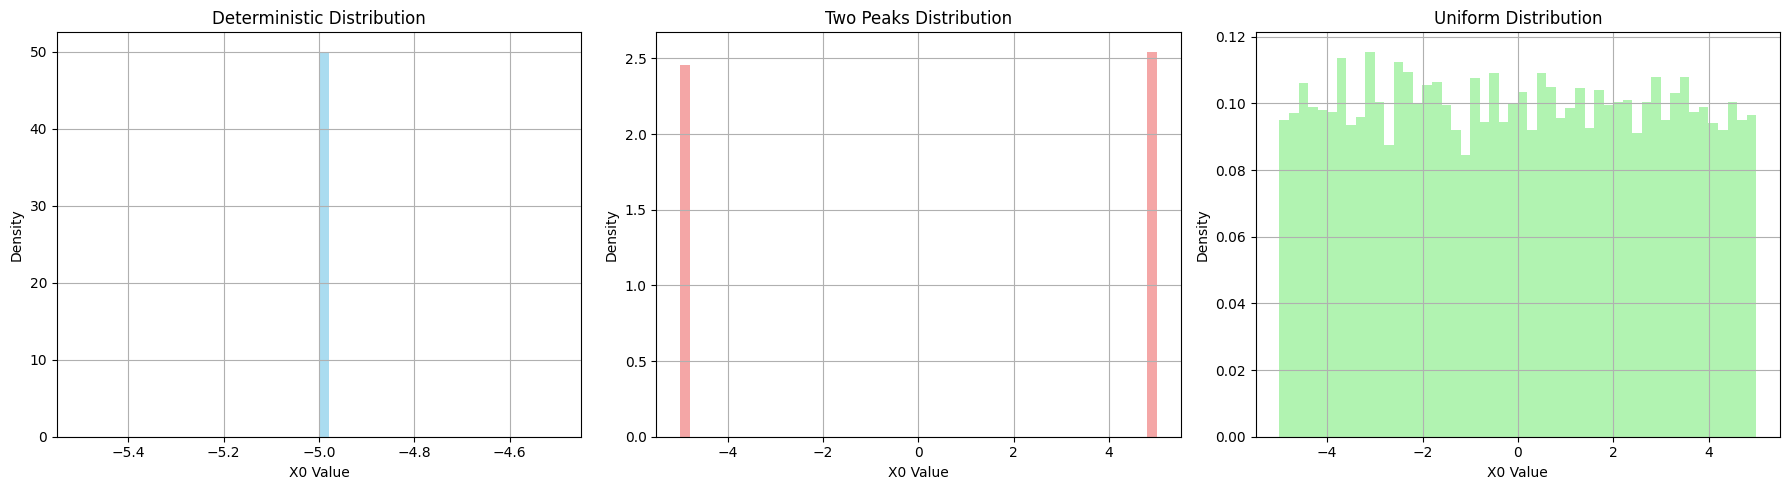

In [15]:
import matplotlib.pyplot as plt

num_samples = 10000

# Sample from each distribution
sps_deterministic = torch.tensor([sample_x0("deterministic") for _ in range(num_samples)])
sps_two_peaks = torch.tensor([sample_x0("two_peaks") for _ in range(num_samples)])
sps_uniform = torch.tensor([sample_x0("uniform") for _ in range(num_samples)])

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot for 'deterministic' distribution
axes[0].hist(sps_deterministic, bins=50, density=True, alpha=0.7, color='skyblue')
axes[0].set_title('Deterministic Distribution')
axes[0].set_xlabel('X0 Value')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# Plot for 'two_peaks' distribution
axes[1].hist(sps_two_peaks, bins=50, density=True, alpha=0.7, color='lightcoral')
axes[1].set_title('Two Peaks Distribution')
axes[1].set_xlabel('X0 Value')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Plot for 'uniform' distribution
axes[2].hist(sps_uniform, bins=50, density=True, alpha=0.7, color='lightgreen')
axes[2].set_title('Uniform Distribution')
axes[2].set_xlabel('X0 Value')
axes[2].set_ylabel('Density')
axes[2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

### Diffusion process
Transfrom X(t=0) to Gaussion by adding noise

In [16]:
# adding noise --> Gaussian
steps = 100

beta = torch.linspace(0.001, 0.2, steps)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def diffusion(x):
  samples = [x]
  for i in range(steps):
    x = (1-beta[i])**(0.5)*x + beta[i]**(0.5)*torch.randn(num_samples)
    samples.append(x)
  return samples

history_deterministic = diffusion(sps_deterministic)
history_two_peaks = diffusion(sps_two_peaks)
history_uniform=diffusion(sps_uniform)

In [19]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) # Reduced figsize

# Initialize empty histogram plots for each distribution
# These will be updated by the animation function
def init():
    for ax in axes:
        ax.clear()
        ax.set_xlim(-5.5, 5.5)
        ax.set_ylim(0, 0.4) # Adjust y-limit as necessary based on expected density
        ax.grid(True)
    return [] # Return empty list as no artists are explicitly created yet

# Update function for the animation
def update(t):
    for i, (history, title_prefix) in enumerate([
        (history_deterministic, 'Deterministic Distribution'),
        (history_two_peaks, 'Two Peaks Distribution'),
        (history_uniform, 'Uniform Distribution')
    ]):
        axes[i].clear() # Clear previous histogram
        axes[i].hist(history[t], bins=50, density=True, alpha=0.7)
        axes[i].set_xlim(-5.5, 5.5)
        axes[i].set_ylim(0, 0.4) # Ensure consistent y-axis scale
        axes[i].set_title(f'{title_prefix} (t={t})')
        axes[i].set_xlabel('X Value')
        axes[i].set_ylabel('Density')
        axes[i].grid(True)
    return []

# Create the animation
# The number of frames should be steps + 1 because history includes x0 and all 100 steps
anim = animation.FuncAnimation(fig, update, frames=steps + 1, init_func=init, blit=True, interval=100)

# Display the animation
HTML(anim.to_jshtml())

### Model training

In [25]:
import numpy as np

learning_rate = 1e-3
max_iter = 5000
eval_interval = 500
batch_size = 128
intervals = 100

model = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

def get_batch(distribution):
  x_arr = []
  t_arr = []
  eps_arr = []

  for _ in range(batch_size):
    x0 = sample_x0(distribution)
    t = rand.randint(0, intervals - 1)
    eps = np.random.normal(0,1)
    # Ensure alpha_bar[t] is handled as a numpy array for calculation with other floats
    # The result 'xt' will be a float
    xt = alpha_bar[t]**0.5 * x0 + (1-alpha_bar[t])**0.5 * eps
    x_arr.append(xt)
    t_arr.append(t)
    eps_arr.append(eps)
  # Explicitly cast to torch.float32 for model input compatibility
  return torch.tensor([x_arr, t_arr], dtype=torch.float32).T, torch.tensor(eps_arr, dtype=torch.float32)

def loss_fn(model, distribution):
  input, epsilons = get_batch(distribution)
  espilon_pred = model(input)
  return F.mse_loss(epsilons, espilon_pred.view(-1))


def train(model, distribution):
  total_params = sum(p.numel() for p in model.parameters())
  print(f"Total number of individual trainable parameters: {total_params}")

  optimizer = torch.optim.AdamW(model.parameters())
  for iter in range(max_iter):
    loss = loss_fn(model, distribution)

    if iter % eval_interval == 0:
      print(f"step {iter}: train loss {loss.item():.4f}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


models = []
for distribution in x0_distributions:
  print(f"Training model for x0: {distribution}")
  model = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32,1))
  train(model, distribution)
  models.append(model)

Training model for x0: deterministic
Total number of individual trainable parameters: 129
step 0: train loss 11.3897
step 500: train loss 0.7274
step 1000: train loss 0.4920
step 1500: train loss 0.2694
step 2000: train loss 0.1515
step 2500: train loss 0.1169
step 3000: train loss 0.1804
step 3500: train loss 0.1749
step 4000: train loss 0.1451
step 4500: train loss 0.0989
Training model for x0: two_peaks
Total number of individual trainable parameters: 129
step 0: train loss 18.4755
step 500: train loss 0.8155
step 1000: train loss 0.6284
step 1500: train loss 0.5904
step 2000: train loss 0.4551
step 2500: train loss 0.5097
step 3000: train loss 0.3382
step 3500: train loss 0.4002
step 4000: train loss 0.2544
step 4500: train loss 0.2301
Training model for x0: uniform
Total number of individual trainable parameters: 129
step 0: train loss 21.0997
step 500: train loss 0.6233
step 1000: train loss 0.4703
step 1500: train loss 0.3790
step 2000: train loss 0.4525
step 2500: train loss 0.

### Sampling

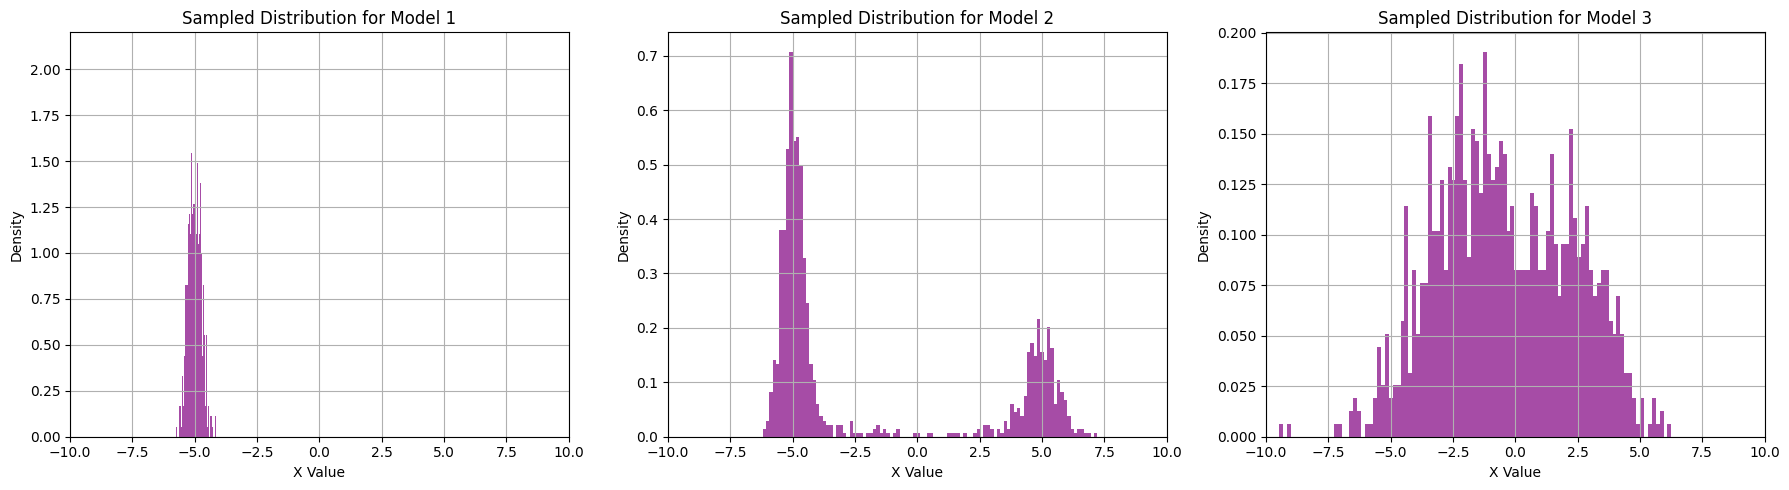

In [30]:
# sampling

def sample(model):
  xt = torch.randn(1)
  with torch.no_grad():
    for t in range(intervals - 1, -1, -1):
      z = 0
      if t > 0:
        z = np.random.normal(0, 1)
      input = torch.tensor([xt, t], dtype=torch.float32)
      xt = alpha[t]**(-.5) * (xt - (1-alpha[t]) * (1-alpha_bar[t])**(-.5) * model(input)) + beta[t] **(0.5) * z
  return xt

# Create a figure with three subplots in one row for sampling results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot for each model
for i, model in enumerate(models):
  x = [sample(model).item() for _ in range(1000)] # Use _ for unused loop variable
  axes[i].hist(x, bins=100, density=True, alpha=0.7, color='purple')
  axes[i].set_title(f'Sampled Distribution for Model {i+1}')
  axes[i].set_xlim(-10, 10)
  axes[i].set_xlabel('X Value')
  axes[i].set_ylabel('Density')
  axes[i].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()